In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
from moexalgo import Market, Ticker
# Акции SBER
sber = Ticker('SBER')

# Все акции
stocks = Market('stocks')


In [3]:
# считывание данных. условия считывания - разделитель десятичных точка, разделитель столбцов точка в запятой
df = pd.read_csv('Norm8Dataset.csv',  sep=';', index_col=None)


In [4]:
df['TimeValue'] = pd.to_datetime(df.TimeValue)

In [5]:
#df['PrognozTime'] = pd.to_datetime(df.PrognozTime)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7816600 entries, 0 to 7816599
Data columns (total 23 columns):
 #   Column            Dtype         
---  ------            -----         
 0   TimeValue         datetime64[ns]
 1   ticker            object        
 2   NormPrognozValue  float64       
 3   val               float64       
 4   val_b             float64       
 5   val_s             float64       
 6   disb              float64       
 7   vol               int64         
 8   trades            int64         
 9   trades_b          int64         
 10  trades_s          int64         
 11  vol_b             int64         
 12  vol_s             int64         
 13  Normpr_open       float64       
 14  Normpr_high       float64       
 15  Normpr_low        float64       
 16  Normpr_close      float64       
 17  Normpr_vwap       float64       
 18  Normpr_vwap_b     float64       
 19  Normpr_vwap_s     float64       
 20  pr_change         float64       
 21  pr_std  

In [7]:
# Создание категориальных переменных по характеристикам времени для входа в модель CatBoost
df['dayofweek'] = df['TimeValue'].dt.dayofweek
df['quarter'] = df['TimeValue'].dt.quarter
df['month'] = df['TimeValue'].dt.month
df['year'] = df['TimeValue'].dt.year
df['dayofyear'] = df['TimeValue'].dt.dayofyear
df['dayofmonth'] = df['TimeValue'].dt.day
#df['weekofyear'] = df['TimeValue'].dt.weekofyear
df['hour'] = df['TimeValue'].dt.hour
df['minute'] = df['TimeValue'].dt.minute
df.columns

Index(['TimeValue', 'ticker', 'NormPrognozValue', 'val', 'val_b', 'val_s',
       'disb', 'vol', 'trades', 'trades_b', 'trades_s', 'vol_b', 'vol_s',
       'Normpr_open', 'Normpr_high', 'Normpr_low', 'Normpr_close',
       'Normpr_vwap', 'Normpr_vwap_b', 'Normpr_vwap_s', 'pr_change', 'pr_std',
       'sector', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'hour', 'minute'],
      dtype='object')

In [8]:
# Определение входных переменных набора
columns_to_train=[ 'ticker',  'vol', 'trades',
       'trades_b', 'trades_s', 'vol_b', 'vol_s',
       'Normpr_open', 'Normpr_high', 'Normpr_low', 'Normpr_close', 'val','pr_std','sector',
       'pr_change', 'val_b', 'val_s', 'disb', 'Normpr_vwap', 'Normpr_vwap_b', 'Normpr_vwap_s',
        'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth',  'hour', 'minute'
]

In [9]:
# создание входного набора данных для обучения и выходного набора по значению закрытия на прогнозе

#X_train_all=df[columns_to_train]
#y_train_all=df['NormPrognozValue']



In [10]:
#model_test = CatBoostRegressor()
#model_test.load_model('catboost_model.bin')

In [11]:
#model_test.predict(X_test)

In [12]:
# Разделение основного набора на обучающую и тестовую выборки
#X_train,X_test,y_train,y_test = train_test_split(X_train_all, 
#                                                 y_train_all, 
#                                                 test_size=0.15, 
#                                                 random_state=45,shuffle=True, stratify=X_train_all['ticker'])

In [13]:
# Разделение основного набора на обучающую и тестовую выборки по TimeSplit
Train_all=df.loc[df['TimeValue']<='2023-10-01']
Test_all=df.loc[df['TimeValue']>'2023-10-01']       
X_train=Train_all[columns_to_train]
X_test=Test_all[columns_to_train]
y_train=Train_all['NormPrognozValue']
y_test=Test_all['NormPrognozValue']

In [14]:
#testnet=X_test
#del df
#del X_train_all
#del y_train_all
#gc.collect()

In [15]:
del df
del Train_all
del Test_all
gc.collect()

77

In [28]:
##### Обучаем 
pool_train_solution = Pool(X_train, y_train,cat_features = ['ticker','sector','dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'hour', 'minute'])

pool_test_solution = Pool(X_test,y_test,cat_features = ['ticker','sector','dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'hour', 'minute'])
#testnet_solution = Pool(testnet,cat_features = ['ticker','dayofweek', 'quarter', 'month', 'year',
#       'dayofyear', 'dayofmonth', 'weekofyear','hour', 'minute'])

model_test = CatBoostRegressor(iterations=1000, learning_rate=0.015,task_type='CPU',depth=8, verbose =True, random_seed=64,#max_leaves=128,
                               leaf_estimation_method= 'Gradient',bootstrap_type= 'MVS',eval_metric = 'MAPE',loss_function= 'MAPE')
#model_test.fit(pool_train_solution,verbose=True)
model_test.fit(pool_train_solution,eval_set=pool_test_solution,verbose=True,early_stopping_rounds=10 )

0:	learn: 0.1810629	test: 0.3247250	best: 0.3247250 (0)	total: 32.1s	remaining: 8h 53m 42s
1:	learn: 0.1681502	test: 0.3106414	best: 0.3106414 (1)	total: 53.8s	remaining: 7h 27m 48s
2:	learn: 0.1558172	test: 0.2966995	best: 0.2966995 (2)	total: 1m 18s	remaining: 7h 16m 3s
3:	learn: 0.1441007	test: 0.2828545	best: 0.2828545 (3)	total: 1m 38s	remaining: 6h 50m 23s
4:	learn: 0.1331081	test: 0.2692033	best: 0.2692033 (4)	total: 1m 59s	remaining: 6h 37m 33s
5:	learn: 0.1228124	test: 0.2560144	best: 0.2560144 (5)	total: 2m 19s	remaining: 6h 25m 41s
6:	learn: 0.1131732	test: 0.2428787	best: 0.2428787 (6)	total: 2m 39s	remaining: 6h 16m 40s
7:	learn: 0.1042063	test: 0.2298270	best: 0.2298270 (7)	total: 2m 59s	remaining: 6h 9m 58s
8:	learn: 0.0959091	test: 0.2171798	best: 0.2171798 (8)	total: 3m 20s	remaining: 6h 8m 7s
9:	learn: 0.0882643	test: 0.2047784	best: 0.2047784 (9)	total: 3m 42s	remaining: 6h 6m 23s
10:	learn: 0.0812412	test: 0.1927196	best: 0.1927196 (10)	total: 4m 1s	remaining: 6h 1m

In [29]:
B=model_test.get_best_iteration()

In [30]:
B

49

In [31]:
A=model_test.get_best_score()
#submission.to_csv('submission_catboost.csv', sep=';', index=False)

In [32]:
A

{'learn': {'MAPE': 0.01629876531661675},
 'validation': {'MAPE': 0.025564264722005136}}

In [33]:

import csv
input_variable = [
    [A],
    [B],]

with open('Example.csv', 'w', newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ' ')
    my_writer.writerow(input_variable)

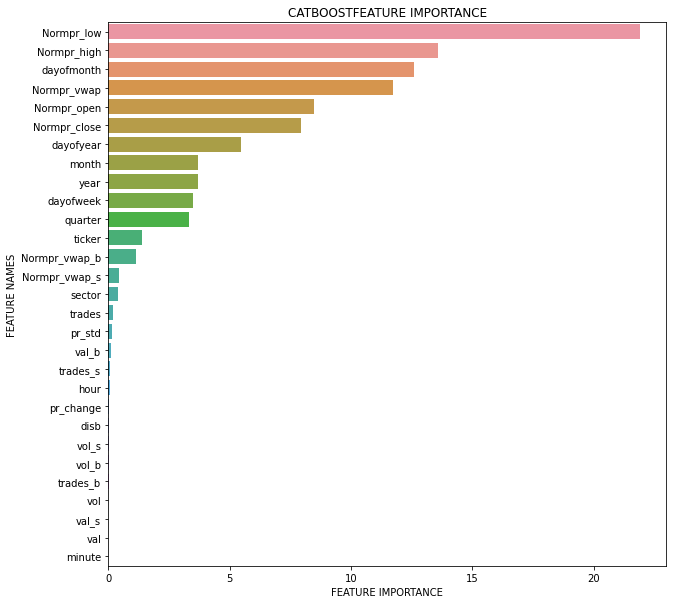

In [34]:
# Значимость признаков CatBoost в модели прогностики

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot the catboost result
plot_feature_importance(model_test.get_feature_importance(),X_train.columns,'CATBOOST')

In [35]:
# сохранение лучшей модели
model_test.save_model('catboost_model_timesplit1.bin')